# Main functions used in experiments

In [73]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm as _tqdm

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer
%matplotlib inline
import matplotlib.pyplot as plt
import sys

import random
import time
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## Environment: Windy gridworld
Gives a reward of -1 for each step taken, while the final state is not reached

In [74]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()
env??

Type:            WindyGridworldEnv
String form:     <WindyGridworldEnv instance>
File:            ~/Desktop/GitHub/RL_reproducibility/windy_gridworld.py
Source:         
class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(sel

## Policy

### Target policy (choose greedy vs non-greedy)
Greedy policy 

In [75]:
class GreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q):
        self.Q = Q
    
    def get_probs(self, state, action):
        """
        Takes a state and an action and returns the probability of taking that action from 
        that state, under Q and a greedy policy
        """   
        # for state and action only:
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        
        if action in max_indices:
            prob = 1/len(max_indices)
        else:
            prob = 0
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """

        best_actions = [i for i, j in enumerate([self.Q[obs][i] for i in range(4)]) 
                   if j == max([self.Q[obs][i] for i in range(4)])] 

        best_action = np.random.choice(best_actions)
        
        return best_action

In [96]:
class EpsilonGreedyPolicy(object):
    """
    A simple epsilon greedy policy.
    """
    def __init__(self, Q, epsilon):
        self.Q = Q
        self.epsilon = epsilon
        
    def get_probs(self, state, action):
        # for one state and action 
        action_probs = self.Q[state]
        max_indices = np.argwhere(action_probs == np.amax(action_probs))
        # all probs are equal, give all equal probabilities
        if len(max_indices) == len(action_probs):
            return 1/len(max_indices)
            
        if action in max_indices:
            prob = (1-self.epsilon)/len(max_indices)
        else:
            prob = epsilon / (len(action_probs) - len(max_indices))
        
        return prob
        
    def sample_action(self, obs):
        """
        This method takes a state as input and returns an action sampled from this policy.  

        Args:
            obs: current state

        Returns:
            An action (int).
        """
#         if (obs == 13): 
#             print(self.Q[obs])
        p = np.random.uniform()
        if p > self.epsilon:
            # choose one of the best actions
            action = np.random.choice([i for i, j in enumerate(self.Q[obs]) if j == np.max(self.Q[obs])])
        else:
            # return a random action
            action = np.random.randint(0,4)
                
        return action


# Monte Carlo

In [77]:
def sample_episode(env, policy):
    """
    A sampling routine. Given environment and a policy samples one episode and returns states, actions, rewards
    and dones from environment's step function and policy's sample_action function as lists.

    Args:
        env: OpenAI gym environment.
        policy: A policy which allows us to sample actions with its sample_action method.

    Returns:
        Tuple of lists (states, actions, rewards, dones). All lists should have same length. 
        state after the termination is not included in the list of states.
    """
    # initialize
    states = []
    actions = []
    rewards = []
    dones = []
    
    # get a starting state
    s = env.reset()
    d = False
    
    # keep looping until done, don's save the terminal state
    while not d:
        states.append(s)
        a = policy.sample_action(s)
        s, r, d, _ = env.step(a)
        
        # save                
        actions.append(a)
        rewards.append(r)
        dones.append(d)
        

    return states, actions, rewards, dones

In [78]:
# check the length of episodes that are generated for eps greedy policy
Q = np.zeros((env.nS, env.nA))
bp = EpsilonGreedyPolicy(Q, epsilon=0.1)

for episode in range(1):
    trajectory_data = sample_episode(env, bp)
    print(f"length of episode {episode}: {len(trajectory_data[0])}")

length of episode 0: 8698


## Importance Sampling


In [79]:
def mc_importance_sampling(env, behavior_policy, target_policy, num_episodes, weighted=False, discount_factor=1.0,
                           sampling_function=sample_episode, epsilon=0.05, seed=42):
    """
    Monte Carlo prediction algorithm. Calculates the Q function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI gym environment.
        behavior_policy: A policy used to collect the data.
        target_policy: A policy which value function we want to estimate.
        num_episodes: Number of episodes to sample.
        weighted: Boolean flag to use weighted or ordinary importance sampling.
        discount_factor: Gamma discount factor.
        sampling_function: Function that generates data from one episode.
    
    Returns:
        A dictionary that maps from (state, action) -> value.
    """

    # set the current Q to a large negative value
    Q = np.ones((env.nS, env.nA)) * -100
    if weighted:
        C = np.zeros((env.nS, env.nA))
    else:
        returns_count = defaultdict(lambda: defaultdict(float))
    
    episode_lens = []
    
    # set seed
    np.random.seed(seed)
    
    # sample episodes
    for i in tqdm(range(num_episodes), position=0):
        # update behavioral and target policy
        behavior_policy.Q = Q
        target_policy.Q = Q        
    
        # sample episode with new behavioural function
        states, actions, rewards, dones = sampling_function(env, behavior_policy)
        
        # save the episode length
        episode_lens.append(len(states)) 

        G = 0        
        W = 1
        
        # loop backwards over the trajectory
        for i, timestep in enumerate(range(len(states)-1, -1, -1)):
            s = states[timestep]
            r = rewards[timestep]
            a = actions[timestep]
            G = discount_factor * G + r
            
            if weighted:
                # add W to the sum of weights C
                C[s][a] += W
                Q[s][a] += W/C[s][a] * (G - Q[s][a])
            else:
                returns_count[s][a] += 1 
                # use every visit incremental method
                Q[s][a] += 1/returns_count[s][a] * (W * G - Q[s][a])
            
            W *= (target_policy.get_probs(s, a)) / (behavior_policy.get_probs(s, a))        

            if W == 0:
                break
        
    return Q, episode_lens

## Performance


In [80]:
# Reproducible
seed = 10

# set other parameters
epsilon = 0.1
gamma = 1.0
num_episodes = 1000
Q = np.ones((env.nS, env.nA)) * -100
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_mc_ordinary, mc_ordinary_epslengths = mc_importance_sampling(env, 
                                                               behavioral_policy, target_policy, 
                                                               num_episodes, weighted=False,discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)
print(f"Updating Q using weighted importance sampling ({num_episodes} episodes)")
Q_mc_weighted, mc_weighted_epslengths = mc_importance_sampling(env, 
                                                               behavioral_policy, target_policy,
                                                               num_episodes, weighted=True, discount_factor=gamma, 
                                                               epsilon=epsilon, seed=seed)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (1000 episodes)


  0%|          | 0/1000 [00:00<?, ?it/s]

Updating Q using weighted importance sampling (1000 episodes)


100%|██████████| 1000/1000 [00:03<00:00, 294.95it/s]


In [81]:
# check how long an episode takes under the found Q function
greedy_ordinary = GreedyPolicy(Q_mc_ordinary)
greedy_weighted = GreedyPolicy(Q_mc_weighted)

ordinary_episode = sample_episode(env, greedy_ordinary)
weighted_episode = sample_episode(env, greedy_weighted)

print(f"resulting episode length ordinary: {len(ordinary_episode[0])}")
print(f"resulting episode length weighted: {len(weighted_episode[0])}")

resulting episode length ordinary: 16
resulting episode length weighted: 17


### Plotting episode lengths during training

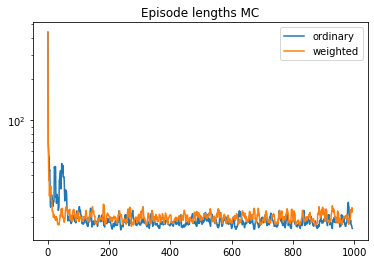

In [82]:
def running_mean(vals, n=1):
    assert n < len(vals)
    cumvals = np.array(vals).cumsum()
    return (cumvals[n:] - cumvals[:-n]) / n 

# set smoothing factor
n = 5

plt.plot(running_mean(mc_ordinary_epslengths, n), label="ordinary")
plt.plot(running_mean(mc_weighted_epslengths, n), label="weighted")
# plt.hlines(num_episodes)
plt.title('Episode lengths MC')
plt.yscale("log")
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

# Temporal Difference

### TO-DO: TD Ordinary Importance Sampling (make it work for gridworld)
Copied from TD_lab. Currently on-policy, needs to be off-policy.

Confused: do we need value functions instead of q-values? Do we even use importance weights in off-policy TD? Are there more off-policy TD methods besides SARSA?

In [83]:
def sarsa(env, policy, Q, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keeps track of useful statistics
    stats = []
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        # initial state is 3,0 in the grid (according to source code)
        s = env.reset()
        a = policy.sample_action(s)
        final_state_reached = False
        
        while True:
            # new actions
            s_prime, r, final_state, _ = env.step(a)
            
            # keep track of stats
            R += r
            i += 1    
            
            # sample action at state s_prime
            a_prime = policy.sample_action(s_prime)

            # update Q 
            Q[s][a] += alpha * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
    
            # update policy
            policy.Q = Q
            
            # if final state, terminate loop
            if final_state:
                break
        
            # update current s and a for next iteration
            s = s_prime
            a = a_prime
            
        stats.append((i, R))
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [104]:
def sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.nS, env.nA)) * -100
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
            
        s = env.reset()
        a = behavior_policy.sample_action(s)
        
        while True:
            # Take action
            s_prime, r, final_state, _ = env.step(a)
            
            # Sample action at from next state
            a_prime = behavior_policy.sample_action(s_prime)
            
            # Update weight
            W = (target_policy.get_probs([s_prime],[a_prime]))/(behavior_policy.get_probs([s_prime],[a_prime]))

            # Update Q 
            Q[s][a] += alpha * W * (r + discount_factor * Q[s_prime][a_prime] - Q[s][a])    
            
            s = s_prime
            a = a_prime
            
            R += r
            i += 1 
            
            if final_state:
                break
            
        stats.append((i, R))
        
#     Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [105]:
s = env.reset()
env.render()
print(s)

o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

30


In [ ]:
def n_step_sarsa_ordinary_importance_sampling(env, behavior_policy, target_policy, num_episodes, n=1, discount_factor=1.0, alpha=0.5):
    """
    n-step SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        n: number of steps
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.nS, env.nA)) * -100
    
    for i_episode in tqdm(range(num_episodes)):
        i = 0
        R = 0
        
        behavior_policy.Q = Q
        target_policy.Q = Q
        
        s = defaultdict(lambda: defaultdict(float))
        a = defaultdict(lambda: defaultdict(float))
        r = defaultdict(lambda: defaultdict(float))
            
        s[0] = env.reset()
        a[0] = behavior_policy.sample_action(s[0])
        
        T = np.inf
        t = 0
        while True:
            if t < T:
                # Take action
                s[t+1], r[t+1], final_state, _ = env.step(a[t])
                R += r[t+1]
                i += 1
                
                if final_state:
                    T = t + 1
                else:
                    # Sample action from next state
                    a[t+1] = behavior_policy.sample_action(s[t+1])
            
            tau = t - n + 1
            
            if tau >= 0:
                # Collect states and actions included in ratio
                last_step_rho = min([tau + n, T - 1])
                first_step = tau + 1
                states = [value for key, value in s.items() if key in range(first_step, last_step_rho+1)]
                actions = [value for key, value in a.items() if key in range(first_step, last_step_rho+1)]
                
                # n-step importance sampling ratio
                rho = np.prod([(target_policy.get_probs([state],[action]))/(behavior_policy.get_probs([state],[action])) for state, action in zip(states, actions)])
                
                # n-step return
                last_step_G = min([tau + n, T])
                G = np.sum([discount_factor**(i - tau - 1) * r[i] for i in range(first_step, last_step_G)])
                if tau + n < T:
                    G += discount_factor**n * Q[s[tau+n]][a[tau+n]]

                # Update Q - ordinary importance sampling: divided by number of steps? 
                Q[s[tau]][a[tau]] += alpha * rho * (G - Q[s[tau]][a[tau]]) / (last_step_rho+1 - first step)

            if tau == T - 1:
                break
                         
            t += 1

        stats.append((i, R))
        
    Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

### TO-DO: TD Weighted Importance Sampling (same as above but weighted)

In [85]:
## TD weighted importance sampling

In [135]:
def sarsa_weigthed_importance_sampling(env, behavior_policy, target_policy, num_episodes, discount_factor=1.0, alpha=0.5):
    """
    SARSA algorithm: Off-policy TD control. Calculates the value function
    for a given target policy using behavior policy and ordinary importance sampling.
    
    Args:
        env: OpenAI environment.
        target policy: A policy which allows us to sample actions with its sample_action method.
        behaviour policy: A policy which allows us to sample actions with its sample_action method.
        Q: Q value function, numpy array Q[s,a] -> state-action value.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        
    Returns:
        A tuple (Q, stats).
        Q is a numpy array Q[s,a] -> state-action value.
        stats is a list of tuples giving the episode lengths and returns.
    """
    
    # Keep track of useful statistics
    stats = []
    
    Q = np.ones((env.nS, env.nA))
    C = np.zeros((env.nS, env.nA))
    
    s = defaultdict(lambda: defaultdict(float))
    a = defaultdict(lambda: defaultdict(float))
    r = defaultdict(lambda: defaultdict(float))
    
    s[0] = env.reset()
    a[0] = behavior_policy.sample_action(s[0])
    
    T = np.inf
        t = 0
        while True:
            if t < T:
                # Take action
                s[t+1], r[t+1], final_state, _ = env.step(a[t])
                R += r[t+1]
                i += 1
                
                if final_state:
                    T = t + 1
                else:
                    # Sample action from next state
                    a[t+1] = behavior_policy.sample_action(s[t+1])
            
            tau = t - n + 1
            
            if tau >= 0:
                # Collect states and actions included in ratio
                last_step_rho = min([tau + n, T - 1])
                first_step = tau + 1
                states = [value for key, value in s.items() if key in range(first_step, last_step_rho+1)]
                actions = [value for key, value in a.items() if key in range(first_step, last_step_rho+1)]
                
            # n-step importance sampling ratio
#             rho = np.prod([(target_policy.get_probs([state],[action]))/(behavior_policy.get_probs([state],[action])) for state, action in zip(states, actions)])

            # n-step return
            last_step_G = min([tau + n, T])
            G = np.sum([discount_factor**(i - tau - 1) * r[i] for i in range(first_step, last_step_G)])
            if tau + n < T:
                G += discount_factor**n * Q[s[tau+n]][a[tau+n]]

            # Update Q - for weigted sampling rho/rho is 1 
            Q[s[tau]][a[tau]] += alpha * (G - Q[s[tau]][a[tau]])

            if tau == T - 1:
                break
                         
            t += 1

        stats.append((i, R))
        
    Q = Qdefaultdict2array(Q, env.nA, env.nS)
        
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

In [136]:
# Reproducible
np.random.seed(42)

# set other parameters
epsilon = 0.05
discount_factor = 1.0
num_episodes = 100
alpha=0.5
Q = np.ones((env.nS, env.nA)) * -100
behavioral_policy = EpsilonGreedyPolicy(Q, epsilon=epsilon)
target_policy = GreedyPolicy(Q)

# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_td_ordinary, td_ordinary_epsstats = sarsa_ordinary_importance_sampling(env, behavioral_policy, target_policy, 
                                                                        num_episodes, discount_factor, alpha)

n=4
# the episode length is equal to the negative return. 
print(f"Updating Q using ordinary importance sampling ({num_episodes} episodes)")
Q_td_nstep_weigthed, td_nstep_weighted_epsstats = sarsa_weigthed_importance_sampling(env, behavioral_policy, target_policy, 
                                                                        num_episodes, discount_factor, alpha)

  0%|          | 0/100 [00:00<?, ?it/s]

Updating Q using ordinary importance sampling (100 episodes)
i:  54 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-100. -100. -100. -100.]
C:  1.10803324099723
i:  55 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-100. -100. -100. -100.]
C:  1.10803324099723
i:  98 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-100.  -100.5 -100.5 -100. ]
C:  1.10803324099723
i:  159 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  

  1%|          | 1/100 [00:01<02:28,  1.50s/it]

i:  21 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.42415197 -101.24812103 -101.26986148 -101.35830049]
C:  9.213296398891966
i:  23 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.42415197 -101.38156567 -101.26986148 -101.35830049]
C:  10.213296398891966
i:  24 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.42415197 -101.38156567 -101.26986148 -101.35830049]
C:  8.10803324099723
i:  25 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o 

  3%|▎         | 3/100 [00:02<01:56,  1.20s/it]

i:  53 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.5772656  -101.58563307 -101.56034284 -101.63023703]
C:  14.213296398891966
i:  54 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.5772656  -101.58563307 -101.56034284 -101.63023703]
C:  14.10803324099723
i:  55 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.5772656  -101.58563307 -101.59578364 -101.63023703]
C:  14.10803324099723
i:  126 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  

  7%|▋         | 7/100 [00:04<01:31,  1.02it/s]

i:  143 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.8775148  -101.79967985 -101.81409368 -101.84544386]
C:  22.213296398891966
i:  185 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.8775148  -101.85907547 -101.81409368 -101.84544386]
C:  5.10803324099723
i:  186 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-101.8775148  -101.85907547 -101.81409368 -101.84544386]
C:  23.10803324099723
i:  187 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o

 13%|█▎        | 13/100 [00:05<01:04,  1.34it/s]

i:  194 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.01339876 -102.00423484 -101.96555377 -101.96062574]
C:  27.213296398891966
i:  41 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.01339876 -102.00423484 -101.96555377 -101.99359894]
C:  28.213296398891966
i:  42 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.01339876 -102.00423484 -101.96555377 -101.99359894]
C:  31.10803324099723
i:  43 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o 

 19%|█▉        | 19/100 [00:06<00:46,  1.74it/s]

i:  324 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.07097643 -102.08433472 -102.05504968 -102.05315252]
C:  32.21329639889197
i:  15 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.07097643 -102.08433472 -102.05504968 -102.080615  ]
C:  7.052631578947368
i:  16 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.07097643 -102.08433472 -102.05504968 -102.080615  ]
C:  37.10803324099723
i:  17 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o

 25%|██▌       | 25/100 [00:07<00:35,  2.13it/s]

i:  40 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.21217548 -102.21838609 -102.19680351 -102.19702846]
C:  39.21329639889197
i:  48 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.21217548 -102.21838609 -102.19680351 -102.19702846]
C:  40.21329639889197
i:  49 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.21217548 -102.21838609 -102.19680351 -102.19702846]
C:  49.10803324099723
i:  50 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o 

 33%|███▎      | 33/100 [00:09<00:24,  2.70it/s]

i:  15 a:  0
33 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.28827964 -102.27437417 -102.25499778 -102.25463165]
C:  11.10803324099723
i:  18 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.28827964 -102.27437417 -102.25499778 -102.27256287]
C:  45.21329639889197
i:  19 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.28827964 -102.27437417 -102.25499778 -102.27256287]
C:  55.10803324099723
i:  20 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o 

 38%|███▊      | 38/100 [00:10<00:20,  3.05it/s]

i:  70 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.32270401 -102.32513939 -102.3233524  -102.33726519]
C:  12.052631578947368
i:  74 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.35489173 -102.32513939 -102.3233524  -102.33726519]
C:  50.21329639889197
i:  75 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.35489173 -102.32513939 -102.3233524  -102.33726519]
C:  63.10803324099723
i:  76 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o

 47%|████▋     | 47/100 [00:11<00:13,  3.79it/s]

i:  43 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.38529567 -102.39384655 -102.37634458 -102.38073965]
C:  55.21329639889197
i:  44 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.38529567 -102.39384655 -102.37634458 -102.38073965]
C:  70.10803324099723
i:  45 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.38529567 -102.39384655 -102.38347643 -102.38073965]
C:  70.10803324099723
i:  163 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o

 58%|█████▊    | 58/100 [00:12<00:09,  4.65it/s]

i:  142 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.46619183 -102.45524488 -102.45602977 -102.45662592]
C:  63.21329639889197
i:  159 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.46619183 -102.47441393 -102.45602977 -102.45662592]
C:  18.05263157894737
i:  160 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.46619183 -102.47441393 -102.45602977 -102.45662592]
C:  82.10803324099723
i:  161 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o

 69%|██████▉   | 69/100 [00:13<00:05,  5.58it/s]

i:  46 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.51398125 -102.52815251 -102.51382476 -102.52163923]
C:  70.21329639889197
i:  47 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.51398125 -102.52815251 -102.51382476 -102.52163923]
C:  92.10803324099723
i:  48 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.51398125 -102.52815251 -102.51925317 -102.52163923]
C:  92.10803324099723
i:  5 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  

 78%|███████▊  | 78/100 [00:14<00:03,  6.25it/s]

i:  57 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.57823557 -102.57694809 -102.56562611 -102.56955583]
C:  76.21329639889197
i:  58 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.57823557 -102.57694809 -102.56562611 -102.56955583]
C:  102.10803324099723
i:  59 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.57823557 -102.57694809 -102.57052288 -102.56955583]
C:  102.10803324099723
i:  11 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  

 90%|█████████ | 90/100 [00:15<00:01,  7.29it/s]

i:  29 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.61666673 -102.62140692 -102.60806086 -102.61262739]
C:  81.21329639889197
i:  30 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.61666673 -102.62140692 -102.60806086 -102.61262739]
C:  111.10803324099723
i:  31 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.61666673 -102.62140692 -102.61256098 -102.61262739]
C:  112.10803324099723
i:  32 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  

100%|██████████| 100/100 [00:16<00:00,  7.86it/s]

i:  28 a:  3
24 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.66898171 -102.66234616 -102.65956045 -102.66652253]
C:  30.05263157894737
i:  29 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.66898171 -102.66234616 -102.65956045 -102.66652253]
C:  123.10803324099723
i:  30 a:  2
13 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

[-102.66898171 -102.66234616 -102.66362192 -102.66652253]
C:  123.10803324099723
i:  39 a:  1
12 13
o  o  o  o  o  o  o  o  o  o
o  o  o  x  o  o  o  o  o  o
o  o  o  o  

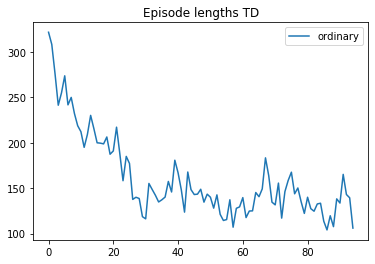

In [134]:
# ,import plotly.graph_objects as go

n = 5

rm = running_mean(td_nstep_ordinary_epsstats[0], n)

# fig = go.Figure(go.Scatter(x=list(range(len(rm))), y=rm))
# fig.show()

plt.plot(rm, label="ordinary")
plt.title('Episode lengths TD')
plt.legend()
# plt.gca().set_ylim([0, 100])
plt.show()

## Experiments